# Detecting Drift on Weather Dataset Partitions

In this tutorial, we'll use a weather dataset to demonstrate how to detect drift on partitions of a dataset. The weather dataset contains hourly weather observations from 36 weather stations in Moscow, Russia. The dataset is available on [Kaggle](https://www.kaggle.com/muthuj7/weather-dataset).

First, we'll import the necessary libraries and load the dataset. Download the dataset and place it in the `data` directory, within this `examples` directory.

In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
import pandas as pd
from gate import summarize, detect_drift

In [3]:
# Load and process data types

all_data = pd.read_csv('data/weatherHistory.csv')
all_data["Formatted Date"] = pd.to_datetime(all_data["Formatted Date"], utc=True)
all_data = all_data.sort_values("Formatted Date")

In [4]:
# Partition data by date and print some values

all_data["year_quarter"] = all_data["Formatted Date"].dt.year.astype(str) + "_" + all_data["Formatted Date"].dt.quarter.astype(str)


# Drop partitions that have less than 100 rows
all_data = all_data.groupby("year_quarter").filter(lambda x: len(x) > 100).reset_index(drop=True)

print("Num partitions: ", len(all_data["year_quarter"].unique()))
print("Num rows: ", len(all_data))

all_data.head()

Num partitions:  44
Num rows:  96452


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,year_quarter
0,2006-01-01 00:00:00+00:00,Mostly Cloudy,rain,1.161111,-3.238889,0.85,16.6152,139.0,9.9015,0.0,1016.15,Mostly cloudy throughout the day.,2006_1
1,2006-01-01 01:00:00+00:00,Mostly Cloudy,rain,1.666667,-3.155556,0.82,20.2538,140.0,9.9015,0.0,1015.87,Mostly cloudy throughout the day.,2006_1
2,2006-01-01 02:00:00+00:00,Overcast,rain,1.711111,-2.194444,0.82,14.4900,140.0,9.9015,0.0,1015.56,Mostly cloudy throughout the day.,2006_1
3,2006-01-01 03:00:00+00:00,Mostly Cloudy,rain,1.183333,-2.744444,0.86,13.9426,134.0,9.9015,0.0,1014.98,Mostly cloudy throughout the day.,2006_1
4,2006-01-01 04:00:00+00:00,Mostly Cloudy,rain,1.205556,-3.072222,0.85,15.9068,149.0,9.9820,0.0,1014.08,Mostly cloudy throughout the day.,2006_1


Note that our partition key is the quarter and year of the observation. We'll use this partition key to detect drift on each partition. We expect that the weather in each quarter of the year will be similar, but maybe some of the data is missing or the weather is different.

## Compute Partition Summaries

We'll now use GATE to compute partition summaries.

In [5]:
# Specify columns to compute summary statistics for

columns = all_data.columns.to_list()
columns.remove("Formatted Date")
columns.remove("year_quarter")

In [6]:
columns

['Summary',
 'Precip Type',
 'Temperature (C)',
 'Apparent Temperature (C)',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Loud Cover',
 'Pressure (millibars)',
 'Daily Summary']

In [7]:
summaries = summarize(all_data, columns=columns, partition_key="year_quarter")

print("Num summaries: ", len(summaries)) # Should be one per partition

Num summaries:  44


We can print out a summary of the dataset to see what the data looks like.

In [8]:
summaries[0].value

statistic,year_quarter,column,coverage,mean,num_unique_values,occurrence_ratio,p95,stdev
0,2006_1,Apparent Temperature (C),1.0,-1.689576,NaN,NaN,11.927778,6.647509
1,2006_1,Daily Summary,1.0,NaN,40.0,0.100000,NaN,NaN
2,2006_1,Humidity,1.0,0.818120,NaN,NaN,0.960000,0.125698
3,2006_1,Loud Cover,1.0,0.000000,NaN,NaN,0.000000,0.000000
4,2006_1,Precip Type,1.0,NaN,2.0,0.539815,NaN,NaN
5,2006_1,Pressure (millibars),1.0,997.689194,NaN,NaN,1036.520000,145.909987
6,2006_1,Summary,1.0,NaN,12.0,0.328704,NaN,NaN
7,2006_1,Temperature (C),1.0,0.972114,NaN,NaN,11.927778,5.668226
8,2006_1,Visibility (km),1.0,8.334694,NaN,NaN,15.375500,3.880713
9,2006_1,Wind Bearing (degrees),1.0,184.213889,NaN,NaN,344.000000,108.572516


## Detect Drift

With the partition summaries, we can now detect drift on each partition. We'll use the `detect_drift` function to detect drift on each partition. 

For each partition, we detect drift with respect to its earlier partition summaries. We skip the first few partitions, since there aren't many partitions to compare them to.

We pass in `clustering=False` to disable clustering on columns.

In [9]:
partition_names = [s.partition for s in summaries]

In [10]:
drifted_partitions = {}

for i in range(3, len(summaries)):
    drift_results = detect_drift(summaries[i], summaries[:i], cluster=False)
    if drift_results.score_percentile > 0.9:
        print(f"Drift detected in partition {partition_names[i]}!")
        drifted_partitions[partition_names[i]] = drift_results

Drift detected in partition 2012_1!
Drift detected in partition 2012_2!
Drift detected in partition 2014_4!
Drift detected in partition 2015_4!
Drift detected in partition 2016_4!


### Inspect Drift Summary for First Drifted Partition

Looks like there's some drift in a few of the partitions! We can print out the drift summary to see which columns have drifted. We'll start with the first drifted partition.

In [11]:
def get_summary(partition_name):
    for summary in summaries:
        if summary.partition == partition_name:
            return summary
    return None


partition_name = list(drifted_partitions.keys())[0]
drift_results = drifted_partitions[partition_name]
print(drift_results)

Drift score: 6.5380 (100.00% percentile)
Top drifted columns:
                                  statistic   z-score
column                                               
Apparent Temperature (C)              stdev  2.677466
Summary                   num_unique_values  2.571725
Temperature (C)                       stdev  2.561860
Precip Type                occurrence_ratio -1.641916
Daily Summary             num_unique_values  1.508575
Visibility (km)                       stdev  1.148769
Wind Speed (km/h)                       p95  1.101204
Humidity                              stdev  1.057466
Pressure (millibars)                   mean  0.979729
Wind Bearing (degrees)                stdev  0.934496


The z-scores aren't too high for the drifted columns, but it looks like the distribution of Apparent Temperature has changed. We can plot the distribution of Apparent Temperature for the drifted partition and the previous partitions to see the difference.

The last xtick is the drifted partition. We can see that the variance of Apparent Temperature is higher in the drifted partition.

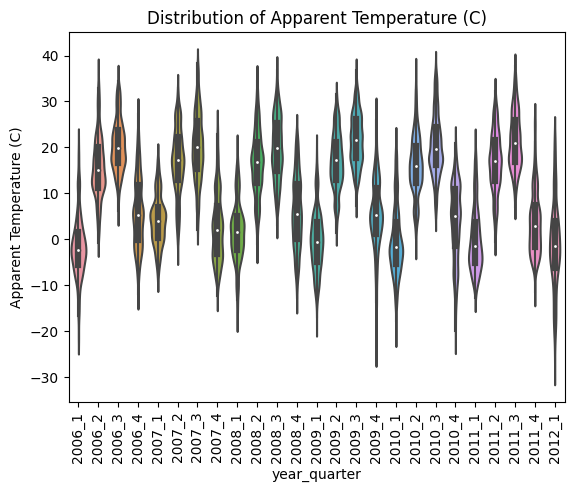

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.violinplot(x="year_quarter", y="Apparent Temperature (C)", data= all_data[all_data["year_quarter"] <= partition_name])
plt.xticks(rotation=90)
plt.title("Distribution of Apparent Temperature (C)")
plt.show()

We can also visualize the distribution of `num_unique_values` for the Summary column to see the difference between the drifted partition and the previous partition. It looks like there were more unique values in the drifted partition!

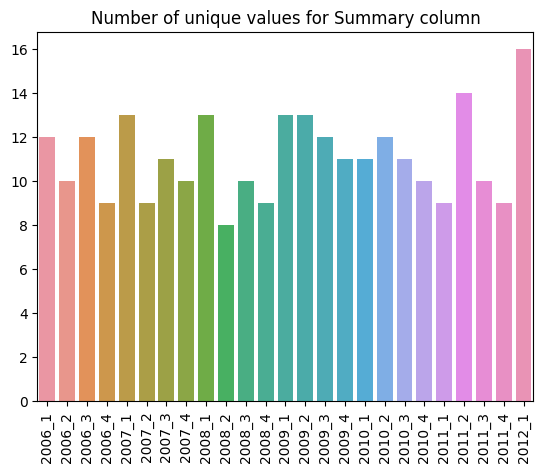

In [38]:
num_unique_values_for_earlier_partitions = {
    pname: get_summary(pname).value.set_index("column").loc["Summary"]["num_unique_values"] for pname in partition_names if pname <= partition_name
}

sns.barplot(x=list(num_unique_values_for_earlier_partitions.keys()), y=list(num_unique_values_for_earlier_partitions.values()))
plt.xticks(rotation=90)
plt.title("Number of unique values for Summary column")
plt.show()

In total, while there was some drift in the drifted partition, it wasn't too severe. We can see that the z-scores for the drifted columns were low. It seems like Q1 2012 had different weather than earlies quarters, but it doesn't seem like the underlying data was corrupted or missing.

### Inspect Drift Summary for Second Drifted Partition

Let's look at the second drifted partition, Q2 2012.

In [39]:
partition_name = list(drifted_partitions.keys())[1]
drift_results = drifted_partitions[partition_name]
print(drift_results)

Drift score: 7.7627 (100.00% percentile)
Top drifted columns:
                                 statistic   z-score
column                                              
Precip Type                       coverage -4.902903
Pressure (millibars)                  mean -2.286108
Visibility (km)                       mean  1.093223
Temperature (C)                      stdev  1.058062
Humidity                             stdev  0.972437
Apparent Temperature (C)               p95  0.822340
Summary                   occurrence_ratio  0.806668
Daily Summary             occurrence_ratio  0.580174
Wind Bearing (degrees)                mean -0.464177
Wind Speed (km/h)                     mean  0.329239


Wow, it looks like the coverage of the Precipitation Type column is lower in the drifted partition. The magnitude of the z-score for the coverage is high. Let's look at the partition summary for the drifted partition.

In [40]:
drifted_ps = get_summary(partition_name)
drifted_ps.value

statistic,year_quarter,column,coverage,mean,num_unique_values,occurrence_ratio,p95,stdev
0,2012_2,Apparent Temperature (C),1.000000,16.975280,NaN,NaN,28.777778,7.423401
1,2012_2,Daily Summary,1.000000,NaN,31.0,0.208791,NaN,NaN
2,2012_2,Humidity,1.000000,0.648732,NaN,NaN,0.930000,0.202323
3,2012_2,Loud Cover,1.000000,0.000000,NaN,NaN,0.000000,0.000000
4,2012_2,Precip Type,0.934524,NaN,3.0,0.926740,NaN,NaN
5,2012_2,Pressure (millibars),1.000000,963.404235,NaN,NaN,1021.400000,216.648099
6,2012_2,Summary,1.000000,NaN,12.0,0.443223,NaN,NaN
7,2012_2,Temperature (C),1.000000,17.318063,NaN,NaN,28.977778,6.990647
8,2012_2,Visibility (km),1.000000,11.651977,NaN,NaN,16.100000,2.779344
9,2012_2,Wind Bearing (degrees),1.000000,184.668040,NaN,NaN,340.000000,105.639926


The lower coverage indicates missing data for precipitation type.

It also looks like the mean of the Pressure column is lower in the drifted partition. You can explore this further if you'd like!

### Inspect Drift Summary for Third Drifted Partition

In [43]:
partition_name = list(drifted_partitions.keys())[2]
drift_results = drifted_partitions[partition_name]
print(f"Looking at partition {partition_name}:")
print(drift_results)

Looking at partition 2014_4:
Drift score: 6.6507 (97.22% percentile)
Top drifted columns:
                                  statistic   z-score
column                                               
Pressure (millibars)                   mean -4.034570
Wind Bearing (degrees)                  p95 -2.421731
Humidity                              stdev -1.502377
Visibility (km)                       stdev  1.476922
Summary                    occurrence_ratio -1.010928
Precip Type               num_unique_values  0.796819
Apparent Temperature (C)              stdev  0.697020
Wind Speed (km/h)                       p95 -0.679354
Temperature (C)                         p95 -0.618799
Daily Summary             num_unique_values  0.251673


Wow, looks like the Pressure column mean is lower in the drifted partition. We can plot the means for this column over time to visualize the distribution shift.

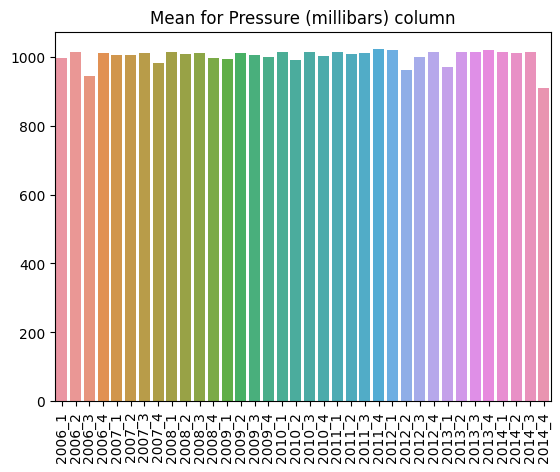

In [45]:
mean_for_earlier_partitions = {
    pname: get_summary(pname).value.set_index("column").loc["Pressure (millibars)"]["mean"] for pname in partition_names if pname <= partition_name
}

sns.barplot(x=list(mean_for_earlier_partitions.keys()), y=list(mean_for_earlier_partitions.values()))
plt.xticks(rotation=90)
plt.title("Mean for Pressure (millibars) column")
plt.show()

And if we visualize the entire distribution of the pressure column, we'll see that there were several low-pressure observations.

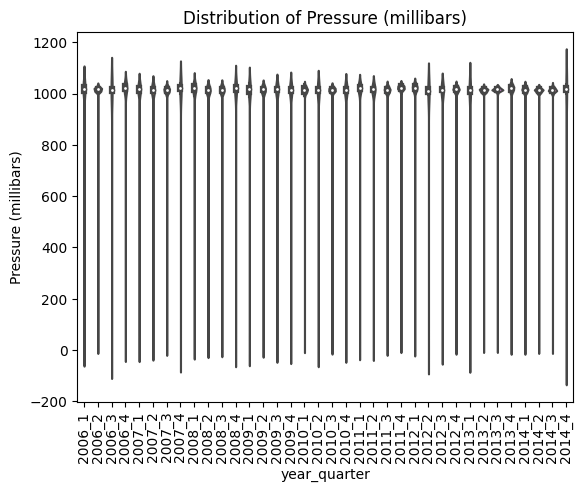

In [46]:
sns.violinplot(x="year_quarter", y="Pressure (millibars)", data= all_data[all_data["year_quarter"] <= partition_name])
plt.xticks(rotation=90)
plt.title("Distribution of Pressure (millibars)")
plt.show()

Additionally, the Wind Bearing (degrees) column has a lower p95, indicating that there were fewer high wind bearing observations in the drifted partition. We can visualize these distributions too.

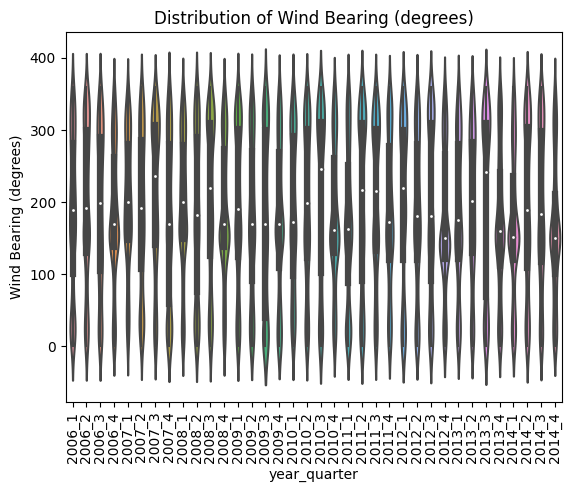

In [47]:
sns.violinplot(x="year_quarter", y="Wind Bearing (degrees)", data= all_data[all_data["year_quarter"] <= partition_name])
plt.xticks(rotation=90)
plt.title("Distribution of Wind Bearing (degrees)")
plt.show()

## Conclusion

We've only inspected a few partitions, but we can see that GATE can detect drift on partitions of a dataset. We can also see that the drift summary can help us understand the drift in each partition.